In [1]:
import numpy as np
import numba
import scipy.sparse as ssp
import scipy.stats
import time
import sys
import pdb
from functools import partial
# %load_ext line_profiler
%load_ext autoreload

import matplotlib.pyplot as plt
plt.rc('text', usetex=True)

In [2]:
from QH_ED import landau
from QH_ED import utils
from QH_ED import hilbert
from functools import partial

In [3]:
# array([-1.95291806, -1.94022948, -1.94022948, -1.93826526, -1.9298701 ,
#        -1.9298701 ])

## Laguerre polynomials

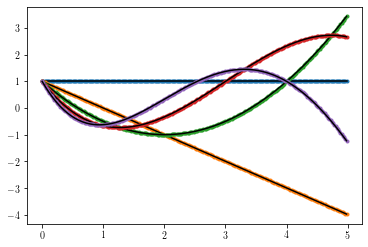

In [4]:
f, ax = plt.subplots()
x = np.r_[0:5:0.02]

f = {0: 1 - 0*x,
     1: 1 - x,
     2: 1 - 2*x + x**2/2,
     3: 1 - 3*x + 1.5*x**2 - x**3/6,
     4: 1 - 4*x + 3*x**2 - 2*x**3/3 + x**4/24}

for m in [0, 1, 2, 3, 4]:
    ax.plot(x, scipy.special.eval_laguerre(m, x), '.', color='C'+str(m))
    ax.plot(x, f[m], color='k')
    

In [9]:
Nphi = 24
Ne = 8
Nth = 4 # numer of threads for parallelization
nLL = 1
torus1 = landau.Torus(Nphi, aspect_ratio=1.0)
vParams = {'power': (1.0, {'n': 1, 'x': np.inf})} # Coulomb power law, Gaussian cut-off
hamParams = {'alpha': 1.0, 'n': nLL, 'Nphi': Nphi} # mass anisotropy, Landau level index

kx, ky, _ = torus1.get_karr()
k2 = kx[:, np.newaxis]**2 + ky**2

pot1 = landau.Potential(torus=torus1, hamParams=hamParams, vParams=vParams)
pot1.setV2()
T4 = np.real(utils.Utils.make4tensorsym(torus1, pot1.V2))

In [10]:
k = np.r_[0.1:10:0.02]
Vk = 2*np.pi/k / (2*np.pi*Nphi)
FF2 = np.exp(-k**2/4)**2 * (1 - nLL*k**2/2)**2

In [11]:
mMax = 10001
mAll = np.arange(mMax, dtype='float64')
mAll[0] = 1e-16
# mAll[8] += 1e-6
Vm = np.zeros(mMax)
for m in np.arange(mMax):
    ## see Yoshioka (4.39)
    if m < 500:
        Vm[m] = np.sqrt(np.pi)/2 * scipy.special.comb(2*m, m) / (2.**(2*m))
    else:
        Vm[m] = 0.5 * (1 - 0.125/m) / np.sqrt(m)


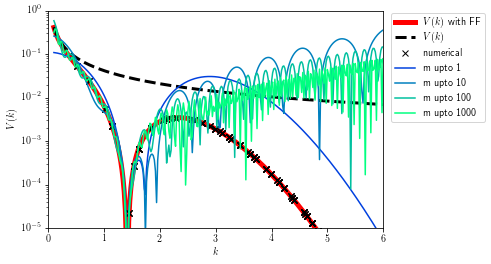

In [12]:
f, ax = plt.subplots()
Vkpp = np.zeros_like(k)

m_arr = [1, 10, 100, 1000]#, 10000]#, 10, 15]


ax.plot(k, Vk*FF2, lw=5, ls = '-', color='r', label=r'$V(k)$ with FF')
ax.plot(k, Vk, lw=3, ls = '--', color='k', label=r'$V(k)$')
ax.plot(np.sqrt(k2.flatten()), np.abs(pot1.V2.flatten()), 'x',
        label='numerical', markeredgecolor='k', markerfacecolor='None')

ctemp = 0
for cm, m in enumerate(np.arange(max(m_arr)+1)):
    Vkpp += 4 * np.pi * Vm[m] * scipy.special.eval_laguerre(m, k**2) / (2 * np.pi * Nphi)
    if m in m_arr:
        ctemp += 1
        ax.plot(k, np.abs(Vkpp*FF2), color=plt.cm.winter(ctemp/len(m_arr)), label='m upto '+str(m))
        
ax.set_yscale('log')
ax.set_xlim(0, 6)
ax.set_ylim(1e-5, 1e0)
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$V(k)$')
ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.01))
# f.savefig('/home/ak20/QH/plots/Vm_Coulomb.pdf', bbox_inches='tight', transparent=True)

## Gaussian interaction

In [17]:
Nphi = 24
Ne = 8
Nth = 4 # numer of threads for parallelization
s = 0.7
nLL = 1
torus1 = landau.Torus(Nphi, aspect_ratio=1.0)
vParams = {'power': (1.0, {'n': 0, 'x': s})} # Gaussian cut-off
hamParams = {'alpha': 1.0, 'n': nLL, 'Nphi': Nphi} # mass anisotropy, Landau level index

kx, ky, _ = torus1.get_karr()
k2 = kx[:, np.newaxis]**2 + ky**2

pot1 = landau.Potential(torus=torus1, hamParams=hamParams, vParams=vParams)
pot1.setV2()
T4 = np.real(utils.Utils.make4tensorsym(torus1, pot1.V2))

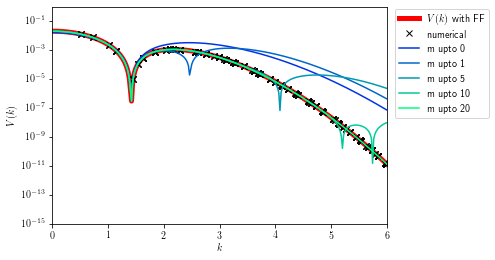

In [18]:
f, ax = plt.subplots()
m_arr = [0, 1, 5, 10, 20]

k = np.r_[0.0:10:0.02]
Vk = 2*np.pi * s**2 * np.exp(-k**2*s**2/2) / (2*np.pi*Nphi)
FF2 = np.exp(-k**2/4)**2 * (1 - nLL*k**2/2)**2
Vm = (s**2/(s**2 + 2))**(np.arange(21)+1)
Vkpp = np.zeros_like(k)

ax.plot(k, Vk*FF2, lw=5, ls = '-', color='r', label=r'$V(k)$ with FF')
# ax.plot(k, Vk, lw=3, ls = '--', color='k', label=r'$V(k)$')

ax.plot(np.sqrt(k2.flatten()), np.abs(pot1.V2.flatten()), 'x', 
        label='numerical', markeredgecolor='k', markerfacecolor='None')

ctemp = 0
for cm, m in enumerate(np.arange(len(Vm))):
    Vkpp += 4 * np.pi * Vm[m] * scipy.special.eval_laguerre(m, k**2) / (2 * np.pi * Nphi)
    if m in m_arr:
        ctemp += 1
        ax.plot(k, np.abs(Vkpp*FF2), color=plt.cm.winter(ctemp/len(m_arr)), label='m upto '+str(m))
        
ax.set_yscale('log')
ax.set_xlim(0, 6)
ax.set_ylim(1e-15, 1e0)
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$V(k)$')
ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1.01))
# f.tight_layout()
# f.savefig('/home/ak20/QH/plots/Vm_Gaussian.pdf', bbox_inches='tight', transparent=True)

(0.99, 1.01)

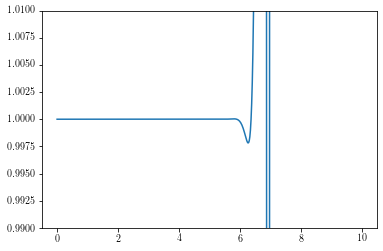

In [38]:
f, ax = plt.subplots()
ax.plot(k, np.abs(Vkpp*FF2)/(Vk*FF2))
ax.set_ylim(0.99, 1.01)

## Other stuff

In [ ]:
E_33_11 = np.load('/tigress/ak20/QH/anisoMayCoulomb/LL0/ar000/Nphi33_Ne11_sector0_alpha10_E.npy')

In [ ]:
E_27_9 = np.zeros((9, 6))
for s in range(9):
    E_27_9[s, :] = np.load('/tigress/ak20/QH/anisoMayCoulomb/LL0/ar000/'+
                           'Nphi{1:d}_Ne{2:d}_sector{0:d}_alpha10_E.npy'.format(s, Nphi, Ne))
    
E_24_8 = np.zeros((8, 6))
for s in range(8):
    E_24_8[s, :] = np.load('/tigress/ak20/QH/anisoMayCoulomb/LL0/ar000/'+
                           'Nphi24_Ne8_sector{0:d}_alpha10_E.npy'.format(s))
    
E_30_10 = np.zeros((10, 6))
for s in range(10):
    E_30_10[s, :] = np.load('/tigress/ak20/QH/anisoMayCoulomb/LL0/ar000/'+
                           'Nphi30_Ne10_sector{0:d}_alpha10_E.npy'.format(s))

In [27]:
np.argmin(E_24_8[:, 0])

4

In [18]:
E_30_10[5, 0] - E_30_10[5, 1]

-0.06302445736917406

In [12]:
E_27_9[0, 0] - E_27_9[0, 1]
# np.sort(E_27_9-np.min(E_27_9))#[0] - E_27_9[1]

-0.05845215551471972

In [15]:
E_33_11[0] - E_33_11[1]

-0.0682452272540921

In [ ]:
Nphi = 24
Ne = 8
Nth = 4 # numer of threads for parallelization
sector = 0

/tigress/ak20/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


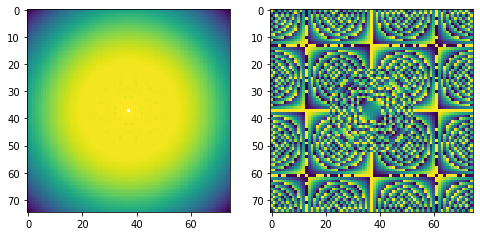

In [5]:
torus1 = landau.Torus(Nphi, aspect_ratio=1.0)
vParams = {'power': {'A': 0.0, 'n': 1, 'x': np.inf}, 
           'haldane': {'A': 1.0, 'Vm': None}} # Coulomb power law, Gaussian cut-off
hamParams= {'alpha': 1.0, 'n': 0, 'Nphi': Nphi} # mass anisotropy, Landau level index

pot1 = landau.Potential()
pot1.setV2(torus1, vParams, hamParams)

f, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].imshow(np.log10(np.abs((pot1.V2))))
ax[1].imshow((np.angle((pot1.V2))))

/tigress/ak20/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


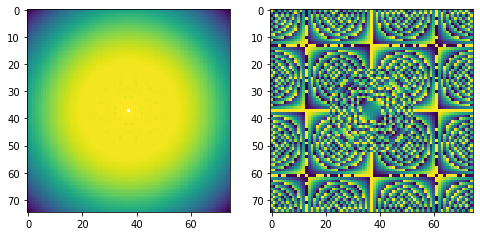

In [6]:
torus1 = landau.Torus(Nphi, aspect_ratio=1.0)
vParams = {'power': {'A': 1.0, 'n': 1, 'x': np.inf}, 
           'haldane': {'A': 0.0, 'Vm': None}} # Coulomb power law, Gaussian cut-off
hamParams= {'alpha': 1.0, 'n': 0, 'Nphi': Nphi} # mass anisotropy, Landau level index

pot2 = landau.Potential()
pot2.setV2(torus1, vParams, hamParams)

f, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].imshow(np.log10(np.abs((pot1.V2))))
ax[1].imshow((np.angle((pot1.V2))))

/tigress/ak20/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/tigress/ak20/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


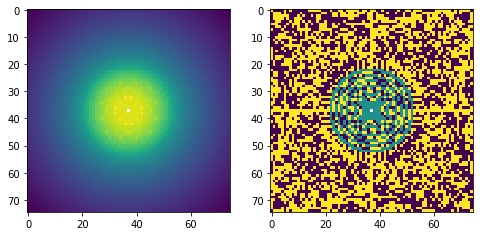

In [7]:
f, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].imshow(np.log10(np.abs((pot2.V2/pot1.V2))))
ax[1].imshow((np.angle((pot1.V2/pot2.V2))))

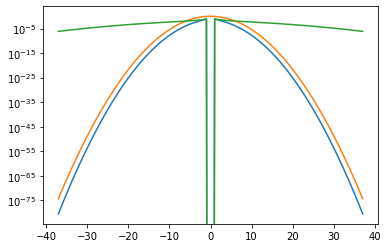

In [20]:
f, ax = plt.subplots()
X = np.arange(-37, 38)

ax.plot(X, np.abs((pot2.V2[37,:])))
ax.plot(X, np.exp(-X**2/(8)))
ax.plot(X, np.abs((pot2.V2[37,:])) / np.exp(-X**2/(8)))
ax.set_yscale('log')

In [8]:
Nphi = 24
Ne = 8
Nth = 4 # numer of threads for parallelization
sector = 0

torus1 = landau.Torus(Nphi, aspect_ratio=1.0)
vParams = {'power': {'A': 0.0, 'n': 1, 'x': np.inf}, 
           'haldane': {'A': 1.0, 'Vm': None}} # Coulomb power law, Gaussian cut-off
hamParams= {'alpha': 1.0, 'n': 0, 'Nphi': Nphi} # mass anisotropy, Landau level index

pot1 = landau.Potential()
pot1.setV2(torus1, vParams, hamParams)
T4 = np.real(utils.Utils.make4tensorsym(torus1, pot1.V2))

hilb_s, hilbLen_s = utils.Utils.getHilb(Nphi, Ne, sector)
dictx = hilbert.getDict(hilb_s)
NH = len(hilb_s)

dij = hilbert.getMatAux(Nphi, Ne, NH, hilb_s, hilbLen_s, T4, dictx, Nth)

HMat = hilbert.dijToCsr(dij, NH)

newMatVec = partial(hilbert.getMatVec, Nphi=Nphi, Ne=Ne, NH=len(hilb_s), hilb=hilb_s, 
                    hilbLen=hilbLen_s, T4=T4, dictx=dictx)
HA = ssp.linalg.LinearOperator((NH, NH), matvec=newMatVec)

In [9]:
Exx, Vxx = ssp.linalg.eigsh(HMat, k=6, which='SA')

In [14]:
Exx[1:] - Exx[:-1]

array([6.71960032e-03, 1.11008855e-03, 1.55431223e-15, 5.59776013e-03,
       1.11022302e-16])

In [11]:
ExxAct = np.array([-1.95291806, -1.94022948, -1.94022948, -1.93826526, -1.9298701 ,
       -1.9298701 ])

In [15]:
ExxAct[1:] - ExxAct[:-1]

array([0.01268858, 0.        , 0.00196422, 0.00839516, 0.        ])

In [16]:
ExxAct

array([-1.95291806, -1.94022948, -1.94022948, -1.93826526, -1.9298701 ,
       -1.9298701 ])

## Haldane vs Coulomb

In [57]:
## Haldane pseudopotential elements

In [7]:
N = 1
Vm = np.zeros(N)
for m in np.arange(1, N, 2):
    ## see Yoshioka (4.39)
    Vm[m] = 0.5* scipy.special.gamma(m + 0.5) / scipy.special.gamma(m+1)

In [67]:
Nphi = 24
Ne = 8
Nth = 4 # numer of threads for parallelization
sector = 0

In [68]:
torus1 = landau.Torus(Nphi, aspect_ratio=1.0)
vParams = {'power': {'A': 0.0, 'n': 1, 'x': np.inf}, 
           'haldane': {'A': 1.0, 'Vm': [0.0, 1.0]}} # Coulomb power law, Gaussian cut-off
hamParams= {'alpha': 1.0, 'n': 0, 'Nphi': Nphi} # mass anisotropy, Landau level index

pot1 = landau.Potential()
pot1.setV2(torus1, vParams, hamParams)
T4 = np.real(utils.Utils.make4tensorsym(torus1, pot1.V2))

hilb = [None]*Ne
hilbLen = [None]*Ne
dictx = [None]*Ne

for sector in range(Ne):
    hilb[sector], hilbLen[sector] = utils.Utils.getHilb(Nphi, Ne, sector)
    dictx[sector] = hilbert.getDict(hilb[sector])

In [69]:
for sector in range(Ne):
    hilb[sector], hilbLen[sector] = utils.Utils.getHilb(Nphi, Ne, sector)
    dictx[sector] = hilbert.getDict(hilb[sector])
    
E_allH = np.zeros((Ne, 6))
V_allH = [None]*Ne

for sector in range(Ne):
    NH = len(hilb[sector])
    dij = hilbert.getMatAux(Nphi, Ne, NH, hilb[sector], hilbLen[sector], T4, dictx[sector], Nth)
    HMat = hilbert.dijToCsr(dij, NH)
    E_allH[sector, :], V_allH[sector] = scipy.sparse.linalg.eigsh(HMat, k=6, which='SA')

In [70]:
E_allH-np.min(E_allH)

array([[0.06758007, 0.06774981, 0.06888969, 0.06888969, 0.06947655,
        0.06947655],
       [0.06578676, 0.06578676, 0.06701789, 0.06701789, 0.06719464,
        0.06971707],
       [0.06701789, 0.06701789, 0.06816072, 0.06816072, 0.06947655,
        0.0859726 ],
       [0.06578676, 0.06578676, 0.06888969, 0.0859726 , 0.0859726 ,
        0.11795105],
       [0.        , 0.06719464, 0.06719464, 0.06758007, 0.09800541,
        0.09800541],
       [0.06578676, 0.06578676, 0.06888969, 0.0859726 , 0.0859726 ,
        0.11795105],
       [0.06701789, 0.06701789, 0.06816072, 0.06816072, 0.06947655,
        0.0859726 ],
       [0.06578676, 0.06578676, 0.06701789, 0.06701789, 0.06719464,
        0.06971707]])

In [71]:
torus1 = landau.Torus(Nphi, aspect_ratio=1.0)
vParams = {'power': {'A': 1.0, 'n': 1, 'x': np.inf}, 
           'haldane': {'A': 0.0, 'Vm': None}} # Coulomb power law, Gaussian cut-off
hamParams= {'alpha': 1.0, 'n': 0, 'Nphi': Nphi} # mass anisotropy, Landau level index

pot1 = landau.Potential()
pot1.setV2(torus1, vParams, hamParams)
T4 = np.real(utils.Utils.make4tensorsym(torus1, pot1.V2))

hilb = [None]*Ne
hilbLen = [None]*Ne
dictx = [None]*Ne

for sector in range(Ne):
    hilb[sector], hilbLen[sector] = utils.Utils.getHilb(Nphi, Ne, sector)
    dictx[sector] = hilbert.getDict(hilb[sector])

In [72]:
for sector in range(Ne):
    hilb[sector], hilbLen[sector] = utils.Utils.getHilb(Nphi, Ne, sector)
    dictx[sector] = hilbert.getDict(hilb[sector])
    
E_allC = np.zeros((Ne, 6))
V_allC = [None]*Ne

for sector in range(Ne):
    NH = len(hilb[sector])
    dij = hilbert.getMatAux(Nphi, Ne, NH, hilb[sector], hilbLen[sector], T4, dictx[sector], Nth)
    HMat = hilbert.dijToCsr(dij, NH)
    E_allC[sector, :], V_allC[sector] = scipy.sparse.linalg.eigsh(HMat, k=6, which='SA')

In [73]:
E_allC - np.min(E_allC)

array([[0.06723096, 0.07991954, 0.07991954, 0.08188375, 0.09027891,
        0.09027891],
       [0.06388024, 0.06388024, 0.06549443, 0.07729499, 0.07729499,
        0.07991954],
       [0.06026558, 0.06026558, 0.07729499, 0.07729499, 0.0783641 ,
        0.0783641 ],
       [0.06388024, 0.06388024, 0.0783641 , 0.0783641 , 0.09132339,
        0.11201483],
       [0.        , 0.06549443, 0.06549443, 0.08188375, 0.08234074,
        0.08234074],
       [0.06388024, 0.06388024, 0.0783641 , 0.0783641 , 0.09132339,
        0.11201483],
       [0.06026558, 0.06026558, 0.07729499, 0.07729499, 0.0783641 ,
        0.0783641 ],
       [0.06388024, 0.06388024, 0.06549443, 0.07729499, 0.07729499,
        0.07991954]])

In [77]:
VC_8 = V_allC[4][:, 0]
VH_8 = V_allH[4][:, 0]

In [75]:
np.dot(VC_9, VH_9)**2

0.9694473136950529

In [78]:
np.dot(VC_9, VH_9)**2, np.dot(VC_8, VH_8)**2, np.dot(VC_7, VH_7)**2, np.dot(VC_6, VH_6)**2

(0.9694473136950529,
 0.9802563915380693,
 0.9920990751095634,
 0.9891017024164663)

In [79]:
VH = {6: VH_6, 7: VH_7, 8: VH_8, 9: VH_9}

In [1]:
cd ../tools


/home/ak20/QH/QH_ED/tools


In [11]:
run runSim2.py 1 /tigress/ak20/QH/anisoMayCoulomb/

39.04770874977112


In [3]:
ls /tigress/ak20/QH/anisoMayCoulomb/LL0/ar000/Nphi24*gr*

/tigress/ak20/QH/anisoMayCoulomb/LL0/ar000/Nphi24_Ne8_sector4_alpha10_gr0.npy


In [12]:
tatti = np.load('/tigress/ak20/QH/anisoMayCoulomb/LL0/ar000/Nphi21_Ne7_sector0_alpha10_gr0.npy')

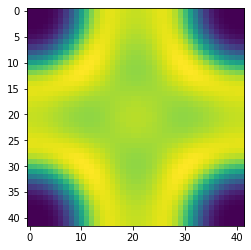

In [13]:
plt.imshow(tatti)

In [19]:
poop0 = np.load('/tigress/ak20/QH/anisoJuneCoulomb/LL0/ar000/HA000/Nphi24_Ne8_sector0_alpha10_E.npy')
poop1 = np.load('/tigress/ak20/QH/anisoJuneCoulomb/LL0/ar000/HA010/Nphi24_Ne8_sector0_alpha10_E.npy')
poop2 = np.load('/tigress/ak20/QH/anisoJuneCoulomb/LL0/ar000/HA020/Nphi24_Ne8_sector0_alpha10_E.npy')
poop3 = np.load('/tigress/ak20/QH/anisoJuneCoulomb/LL0/ar000/HA030/Nphi24_Ne8_sector0_alpha10_E.npy')
poop4 = np.load('/tigress/ak20/QH/anisoJuneCoulomb/LL0/ar000/HA040/Nphi24_Ne8_sector0_alpha10_E.npy')

In [22]:
poop0, poop1, poop2, poop3, poop4

(array([-1.95291806, -1.94022948, -1.94022948, -1.93826526, -1.9298701 ,
        -1.9298701 ]),
 array([-1.98202927, -1.96947424, -1.96947424, -1.9673872 , -1.95933816,
        -1.95933816]),
 array([-2.01140952, -1.99891028, -1.99891028, -1.99678947, -1.98895929,
        -1.98895929]),
 array([-2.04098034, -2.02848296, -2.02848296, -2.02638854, -2.01868854,
        -2.01868854]),
 array([-2.07069093, -2.05815676, -2.05815676, -2.05613069, -2.04849725,
        -2.04849725]))

In [27]:
ls /tigress/ak20/QH/anisoJuneCoulomb/LL1/ar025/HA020/

Nphi24_Ne8_sector0_alpha15_E.npy  Nphi24_Ne8_sector4_alpha15_E.npy
Nphi24_Ne8_sector0_alpha15_V.npy  Nphi24_Ne8_sector4_alpha15_V.npy
Nphi24_Ne8_sector1_alpha15_E.npy  Nphi24_Ne8_sector5_alpha15_E.npy
Nphi24_Ne8_sector1_alpha15_V.npy  Nphi24_Ne8_sector5_alpha15_V.npy
Nphi24_Ne8_sector2_alpha15_E.npy  Nphi24_Ne8_sector6_alpha15_E.npy
Nphi24_Ne8_sector2_alpha15_V.npy  Nphi24_Ne8_sector6_alpha15_V.npy
Nphi24_Ne8_sector3_alpha15_E.npy  Nphi24_Ne8_sector7_alpha15_E.npy
Nphi24_Ne8_sector3_alpha15_V.npy  Nphi24_Ne8_sector7_alpha15_V.npy


In [3]:
alp_arr = np.r_[1.0:4.01:0.1] # 31
asp_arr = np.array([0, 0.25, 0.5])
Ne_arr = np.array([6, 7, 8, 9, 10])
haldaneA_arr = np.array([0.0, 0.1, 0.2, 0.3, 0.4])

E0 = np.zeros((len(haldaneA_arr), len(Ne_arr), len(asp_arr), len(alp_arr), 10, 6)) * np.nan

cf = 0
fol = '/tigress/ak20/QH/anisoJuneCoulomb/'
LL = 1
for cHal, haldaneA in enumerate(haldaneA_arr):
    for cNe, Ne in enumerate(Ne_arr):
        Nphi = 3*Ne
        for casp, ar_factor in enumerate(asp_arr):
            for calp, alpha in enumerate(alp_arr):

                for sector in range(Ne):
                    try:
                        fil = 'Nphi{0:d}_Ne{1:d}_sector{2:d}_alpha{3:d}'.format(
                               Nphi, Ne, sector, int(round(10*alpha)))
                        dat = np.load(fol+'LL{0:d}/ar{1:03d}/HA{2:03d}/'.format(
                                LL, int(round(100*ar_factor)), int(round(100*haldaneA)))+fil+'_E.npy')
                        E0[cHal, cNe, casp, calp, sector, :] = dat
                    except FileNotFoundError:
                        pass

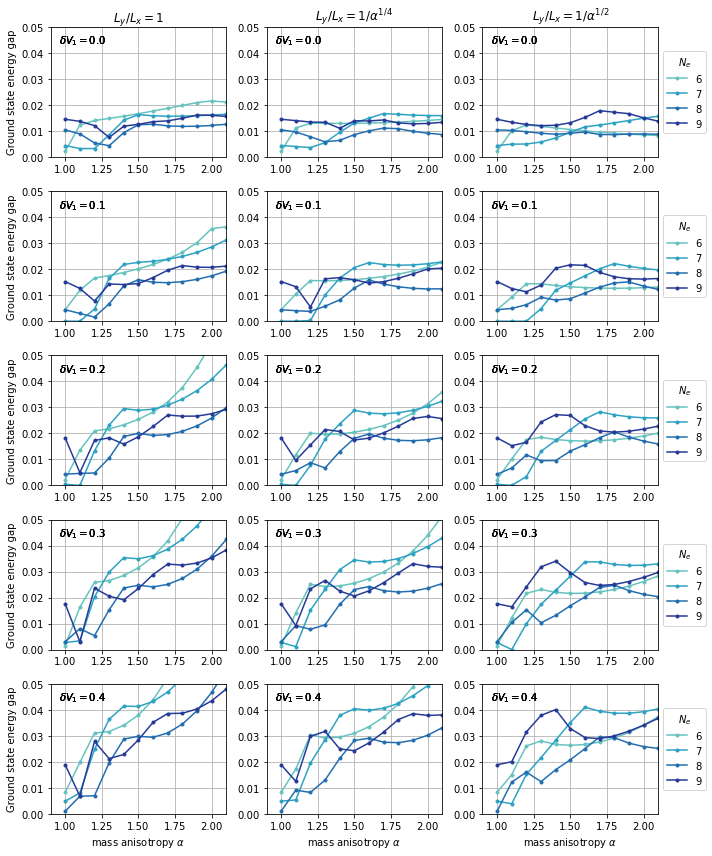

In [15]:
f, axs = plt.subplots(5, 3, figsize=(10, 12))
ylims = [[0.040, 0.065], [0, 0.05]]
LL = 1
spl_title = ['1', r'1/\alpha^{1/4}', r'1/\alpha^{1/2}']
for cHal, haldaneA in enumerate(haldaneA_arr):
    for casp, ar_factor in enumerate(asp_arr):
        for cNe, Ne in enumerate(Ne_arr[:-1]):
            E_Ne_ar = E0[cHal, cNe, casp, :, :, :]
            E_Ne_ar = E_Ne_ar.reshape(31, 60)
            E_Ne_ar = np.sort(E_Ne_ar)
            axs[cHal][casp].plot(alp_arr, E_Ne_ar[:, 1] - E_Ne_ar[:, 0], 
                    label=str(Ne), marker='.', color=plt.cm.YlGnBu((Ne-3)/7))
            axs[cHal][casp].text(0.05, 0.87, r'$\delta V_1 = {0:.1f}$'.format(haldaneA), 
                                 transform=axs[cHal][casp].transAxes)


        if cHal == 4: axs[cHal][casp].set_xlabel(r'mass anisotropy $\alpha$')
        if casp == 0: axs[cHal][casp].set_ylabel(r'Ground state energy gap')
        axs[cHal][casp].set_xlim(0.9, 2.1)
        axs[cHal][casp].set_ylim(ylims[LL])
        if casp == 2: axs[cHal][casp].legend(loc='center left', title=r'$N_e$', 
                                          bbox_to_anchor=(1.00, 0.50))
        if cHal == 0: axs[cHal][casp].set_title(r'$ L_y / L_x = '+spl_title[casp]+'$')
        axs[cHal][casp].grid(True)

f.tight_layout()
f.savefig('/home/ak20/QH/plots/anisoHaldane_LL1.pdf', bbox_inches='tight', transparent=True)

In [ ]:
f, axs = plt.subplots(5, 3, figsize=(10, 12))
ylims = [[0.040, 0.065], [0, 0.05]]
LL = 1
spl_title = ['1', r'1/\alpha^{1/4}', r'1/\alpha^{1/2}']
for cHal, haldaneA in enumerate(haldaneA_arr):
    for casp, ar_factor in enumerate(asp_arr):
        for cNe, Ne in enumerate(Ne_arr[:-1]):
            E_Ne_ar = E0[cHal, cNe, casp, :, :, :]
            E_Ne_ar = E_Ne_ar.reshape(31, 60)
            E_Ne_ar = np.sort(E_Ne_ar)
            axs[cHal][casp].plot(alp_arr, E_Ne_ar[:, 1] - E_Ne_ar[:, 0], 
                    label=str(Ne), marker='.', color=plt.cm.YlGnBu((Ne-3)/7))
            axs[cHal][casp].text(0.05, 0.87, r'$\delta V_1 = {0:.1f}$'.format(haldaneA), 
                                 transform=axs[cHal][casp].transAxes)


        if cHal == 4: axs[cHal][casp].set_xlabel(r'mass anisotropy $\alpha$')
        if casp == 0: axs[cHal][casp].set_ylabel(r'Ground state energy gap')
        axs[cHal][casp].set_xlim(0.9, 2.1)
        axs[cHal][casp].set_ylim(ylims[LL])
        if casp == 2: axs[cHal][casp].legend(loc='center left', title=r'$N_e$', 
                                          bbox_to_anchor=(1.00, 0.50))
        if cHal == 0: axs[cHal][casp].set_title(r'$ L_y / L_x = '+spl_title[casp]+'$')
        axs[cHal][casp].grid(True)

f.tight_layout()
f.savefig('/home/ak20/QH/plots/anisoHaldane_LL1.pdf', bbox_inches='tight', transparent=True)

In [80]:
Ne_arr = np.array([6, 7, 8, 9])
haldaneA_arr = np.array([0.0, 0.1, 0.2, 0.3, 0.4])
ar_factor = 0.0
alpha = 1.0

V0 = {}
E0 = np.zeros((len(haldaneA_arr), len(Ne_arr), 9)) * np.nan

cf = 0
fol = '/tigress/ak20/QH/anisoJuneCoulomb/'
LL = 1
for cHal, haldaneA in enumerate(haldaneA_arr):
    for cNe, Ne in enumerate(Ne_arr):
        Nphi = 3*Ne
        for sector in range(Ne):
            try:
                fil = 'Nphi{0:d}_Ne{1:d}_sector{2:d}_alpha{3:d}'.format(
                       Nphi, Ne, sector, int(round(10*alpha)))
                dat = np.load(fol+'LL{0:d}/ar{1:03d}/HA{2:03d}/'.format(
                        LL, int(round(100*ar_factor)), int(round(100*haldaneA)))+fil+'_V.npy')
                V0[haldaneA, Ne, sector] = dat[:, 0]
                dat = np.load(fol+'LL{0:d}/ar{1:03d}/HA{2:03d}/'.format(
                        LL, int(round(100*ar_factor)), int(round(100*haldaneA)))+fil+'_E.npy')
                E0[cHal, cNe, sector] = dat[0]
            except FileNotFoundError:
                pass

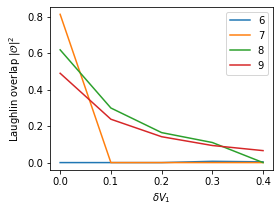

In [91]:
f, ax = plt.subplots(figsize=(4,3))
OV = np.zeros((5, 4))
for cNe, Ne in enumerate(Ne_arr):
    for cHal, haldaneA in enumerate(haldaneA_arr):
        secmin = np.nanargmin(E0[cHal, cNe, :])
        OV[cHal, cNe] = np.abs(np.dot(V0[haldaneA, Ne, secmin], VH[Ne]))**2

    ax.plot(haldaneA_arr, OV[:, cNe], label=str(Ne))
    
ax.legend(loc='best')
ax.set_xlabel(r'$\delta V_1$')
ax.set_ylabel(r'Laughlin overlap $|\mathcal{O}|^2$')
f.savefig('/home/ak20/QH/plots/overlap_Laughlin_LL1.pdf', bbox_inches='tight', transparent=True)

In [85]:
OV

array([[4.97013185e-27, 8.12378378e-01, 6.17795621e-01, 4.89389498e-01],
       [1.07039455e-29, 3.56104447e-31, 2.99135863e-01, 2.37648646e-01],
       [8.01235005e-31, 3.02131464e-30, 1.64304379e-01, 1.41799356e-01],
       [6.98971617e-03, 1.30726350e-28, 1.10016756e-01, 9.35884649e-02],
       [4.04648698e-03, 1.43012335e-29, 2.57188091e-26, 6.55993163e-02]])

In [56]:
whos

Variable       Type          Data/Info
--------------------------------------
E0             ndarray       5x4x9: 180 elems, type `float64`, 1440 bytes
E_allC         ndarray       8x6: 48 elems, type `float64`, 384 bytes
E_allH         ndarray       8x6: 48 elems, type `float64`, 384 bytes
HMat           csr_matrix      (0, 0)	-0.0189453171050<...>623)	-0.31904063239909936
LL             int           1
N              int           1
NH             int           30624
Ne             int64         9
Ne_arr         ndarray       4: 4 elems, type `int64`, 32 bytes
Nphi           int64         27
Nth            int           4
T4             ndarray       24x24: 576 elems, type `float64`, 4608 bytes
V0             dict          n=150
VC_6           ndarray       1038: 1038 elems, type `float64`, 8304 bytes
VC_7           ndarray       5538: 5538 elems, type `float64`, 44304 bytes
VC_8           ndarray       30667: 30667 elems, type `float64`, 245336 bytes (239.5859375 kb)
VH_6           

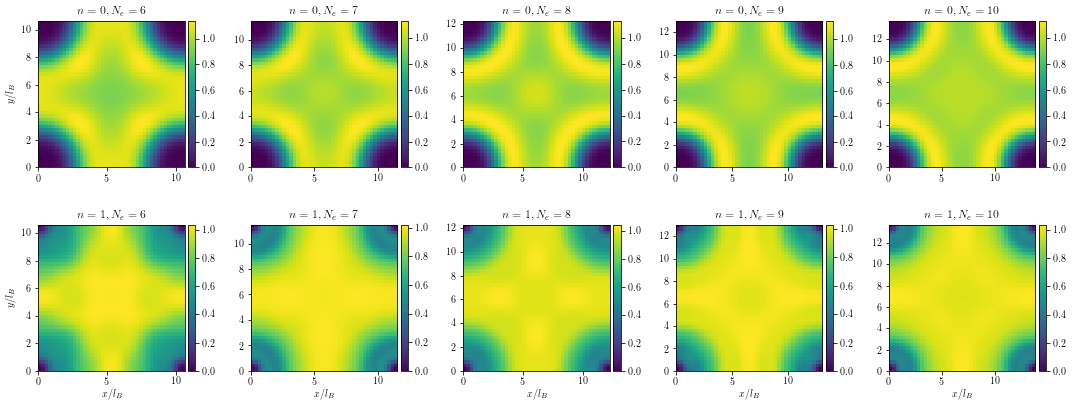

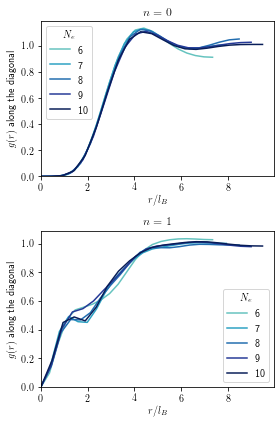

In [25]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

f, ax = plt.subplots(2, 5, figsize=(15, 6))
g, bx = plt.subplots(2, 1, figsize=(4, 6))

Ne_arr = [6,7,8,9,10]
LL_arr = [0,1]
fol = '/tigress/ak20/QH/anisoMayCoulomb/'
ar_factor = 0

for LL in LL_arr:
    for Ne in Ne_arr:
        Nphi = 3*Ne
    
        Eall = np.zeros((Ne, 6))*np.nan
        denom = 2 * np.pi * Nphi / (Ne**2)
        for s in range(Ne):
            Eall[s,:] = np.load(fol+'LL{0:d}/ar{1:03d}/'.format(
                           LL, int(round(100*ar_factor)))+
                           'Nphi{1:d}_Ne{2:d}_sector{0:d}_alpha10_E.npy'.format(
                           s, Nphi, Ne))
        sectorMin = np.nanargmin(Eall[:, 0])
#         print(sectorMin)
        gR1 = np.load(fol+'LL{0:d}/ar{1:03d}/'.format(
                           LL, int(round(100*ar_factor)))+
                           'Nphi{1:d}_Ne{2:d}_sector{0:d}_alpha10_gr0.npy'.format(
                           sectorMin, Nphi, Ne)) * denom

        im1 = ax[LL][Ne-6].imshow(gR1, extent=[0, np.sqrt(2*np.pi*Nphi), 0, np.sqrt(2*np.pi*Nphi)])
        if LL == 1:
            ax[LL][Ne-6].set_xlabel(r'$x / l_B$')
#         else:
        ax[LL][Ne-6].set_title(r'$n = {1:d}, N_e = {0:d}$'.format(Ne, LL))    
        if Ne == 6:
            ax[LL][Ne-6].set_ylabel(r'$y / l_B$')
        divider = make_axes_locatable(ax[LL][Ne-6])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        f.colorbar(im1, cax=cax)
        x_arr = np.sqrt(4*np.pi*Nphi) * np.arange(gR1.shape[0])/(gR1.shape[0] - 1) 
        L = len(x_arr)//2
        bx[LL].plot(x_arr[:L], np.diag(gR1)[:L], color=plt.cm.YlGnBu((Ne-3)/7),
                   label=str(Ne))
    bx[LL].legend(loc='best', title=r'$N_e$')
    bx[LL].set_title(r'$n = {0:d}$'.format(LL))
    bx[LL].set_xlim(0)
    bx[LL].set_ylim(0)
    bx[LL].set_ylabel(r'$g(r)$ along the diagonal')
    bx[LL].set_xlabel(r'$r / l_B$')
        
# # bx.plot(np.sqrt(torus1.Lx**2 + torus1.Ly**2) * np.arange(gR1.shape[0])/(gR1.shape[0] - 1),
# #         np.diag(gR1))
# # bx.set_xlim(0, np.sqrt(torus1.Lx**2 + torus1.Ly**2))
# # bx.set_ylim()


f.tight_layout()
g.tight_layout()
f.savefig('/home/ak20/QH/plots/anisoMay_gr1.pdf', bbox_inches='tight', transparent=True)
g.savefig('/home/ak20/QH/plots/anisoMay_gr2.pdf', bbox_inches='tight', transparent=True)

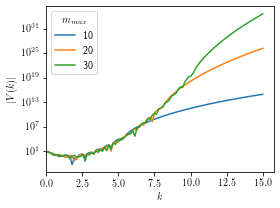

In [50]:
k = np.r_[0:15:101j]
f, ax = plt.subplots(figsize=(4,3))

for cM, M in enumerate([10, 20, 30]):
    Vm = np.zeros(M)
    for m in np.arange(M):
        ## see Yoshioka (4.39)
        Vm[m] = np.sqrt(np.pi)/2 * scipy.special.factorial(2*m) / (
            2**(2*m) * scipy.special.factorial(m)**2)

    Vk = np.zeros_like(k)
    ## see Yoshioka, (4.38)
    for m in np.arange(len(Vm)):
        Vk += 2 * Vm[m] * scipy.special.eval_laguerre(m, k**2)
        
    ax.plot(k, np.abs(Vk), label=str(M))
ax.set_yscale('log')
ax.legend(loc='best', title=r'$m_{max}$')
ax.set_xlim(0)
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$|V(k)|$')
f.tight_layout()
f.savefig('/home/ak20/QH/plots/Haldane_pseudoPot.pdf', bbox_inches='tight', transparent=True)